# Direct TSQR
**Input**: Matrix $A \in \mathbb{R}^{m \times n}$ with $m \gg n$.
1) **First step (local QR)**: The matrix $A$ is split into $p$ row blocks: $A = [A_1^T, A_2^T, \dots, A_p^T]^T$, where $A_j \in \mathbb{R}^{m_j \times n}$. A *map* procedure perform a local QR decomposition independently to each block resulting in $\{(Q^{(1)}_1, R_1),(Q^{(1)}_2, R_2),...,(Q^{(1)}_p, R_p)\}$, where $Q_j^{(1)}\in\mathbb{R}^{m_j\times n}$ and $R_j\in\mathbb{R}^{n\times n}$.
2) **Second step (global QR)**: A *reduce* task collect each local $R_j$ matrices into a $np\times n$ matrix. A second QR decomposition is performed on $R_{\text{stacked}}$ resulting in $\tilde{Q}=[Q^{(2)}_1,...,Q^{(2)}_p]^T \in \mathbb{R}^{np\times n}$ where $Q_j^{(2)}$ is $n\times n$ and $\tilde{R}\in\mathbb{R}^{n\times n}$.
3) **Third step (assembling Q)**: A *map* task build the final $Q$ matrix performing a block-wise matrix multiplication $Q_j=Q_j^{(1)}Q_j^{(2)}$. Concatenating all $Q_j$ vertically gives the final $Q\in \mathbb{R}^{m \times n}$.
---
### Extension to SVD
For the SVD decomposition $A=QR=Q(U_R\Sigma_RV_R^T)=(QU_R)\Sigma_R V^T_R$. The computation of $U$ can be performed in parallel $U_j=Q_j^{(1)}Q_j^{(2)}U_R$.


In [12]:
from dask.distributed import Client, wait
from dask import delayed, compute
import dask.array as da

from numpy.linalg import qr, svd
import numpy as np

N_WORKERS = 12
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "2GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

DASK Client with 12 workers (1 threads, 2GB memory)
Dashboard: http://127.0.0.1:8787/status


In [2]:
def direct_tsqr(A : da.Array, compute_svd : bool = False):
    '''
    Tall-and-skinny QR (or SVD) decomposition via Direct TSQR.

    Parameters
    ----------
    A : dask.array.Array
        Input matrix (m x n) with m >> n, stored as a Dask array.
    compute_svd : bool, optional, default False
        If True, computes the thin SVD decomposition instead of QR.

    Returns
    -------
    If compute_svd is False:
        Q : dask.array.Array, shape (m, n)
        R : dask.array.Array, shape (n, n)
    If compute_svd is True:
        U : dask.array.Array, shape (m, n)
        S : dask.array.Array, shape (n,)
        Vt : dask.array.Array, shape (n, n)
    '''
    n, row_chunks = A.shape[1], A.chunks[0]
    p = len(row_chunks)
    A_blocks = A.to_delayed().ravel().tolist()

    # Step 1: (map) perform QR decomposition in parallel on each block
    QR1 = [delayed(qr)(block) for block in A_blocks]
    Q1s = [qr[0] for qr in QR1]
    R1s = [qr[1] for qr in QR1]

    # Stack R1s vertically
    R1 = delayed(np.vstack)(R1s)

    # Step 2: (reduce) perform global QR decomposition
    QR2 = delayed(qr)(R1)
    Q2, R2 = QR2[0], QR2[1]
    Q2s = [Q2[i*n:(i+1)*n, :] for i in range(p)]

    if compute_svd:
        SVD = delayed(svd)(R2)
        U_R, S, Vt = SVD[0], SVD[1], SVD[2]
        # Step 3: (map) building the final U by multiplying Qs blocks and U_R
        U_blocks = [da.from_delayed(delayed(lambda Q1, Q2, U_R: Q1 @ Q2 @ U_R)(Q1, Q2, U_R),
                    shape=(row_chunks[i], n), dtype=A.dtype)
                    for i, (Q1, Q2) in enumerate(zip(Q1s, Q2s))]
        U = da.concatenate(U_blocks)
        return U, da.from_delayed(S, (n,), dtype=A.dtype), da.from_delayed(Vt, (n, n), dtype=A.dtype)
    else:
        # Step 3: (map) building the final Q by multiplying Qs blocks
        Q_blocks = [da.from_delayed(delayed(lambda Q1, Q2: Q1 @ Q2)(Q1, Q2),
                    shape=(row_chunks[i], n), dtype=A.dtype)
                    for i, (Q1, Q2) in enumerate(zip(Q1s, Q2s))]
        Q = da.concatenate(Q_blocks)
        return Q, da.from_delayed(R2, (n, n), dtype=A.dtype)

### Memory considerations
- **Step 1**: Each worker holds a block of $A$ with shape $m_j\times n$, where $m_j\approx\lceil m/p\rceil$ and $p$ is the number of workers. Each QR decomposition produce a matrix $Q$ and $R$ of dimension $m_j\times n$ and $R$ of $n\times n$ respectively. The QR decomposition rely on `dgeqrf` LAPACK routine and it may require addictional memory allocation, resulting in peak memory usage above $\approx 2m_j n$.
- **Step 2**: The local $R_j$ matrices are stacked vertically to form a matrix of shape $pn\times n$. The global QR decomposition produce a matrix $Q$ and $R$ of  $pn\times n$ for $Q$ and $n\times n$ for $R$. As before, LAPACK routine may increase peak memory usage.
- **Step 3**: Each block multiplies $Q_j^{(1)}Q_j^{(2)}$ to recontruct the final $Q$, then each $Q_j$ is $m_j\times n$. 
$$(2m_j n+n^2)+(2p+1)n^2+m_jn\gtrapprox 3m_j n$$

### Example: random matrix

In [3]:
# Initialization of a distributed random matrix
m, n = int(1e7), 4
chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
chunks.append(m - sum(chunks))
A = da.random.random((m, n), chunks=(chunks, n))

# Persist in memory to avoid recomputation
A = A.persist() 

print(f"Input matrix A: m = {A.shape[0]}, n = {A.shape[1]}")
print(f"The {len(A.chunks[0])} blocks are: {A.chunks[0]}")
print(f"Total size of A: {A.nbytes / 1e6} MB")
A

Input matrix A: m = 10000000, n = 4
The 12 blocks are: (833333, 833333, 833333, 833333, 833333, 833333, 833333, 833333, 833333, 833333, 833333, 833337)
Total size of A: 320.0 MB


dask.array<random_sample, shape=(10000000, 4), dtype=float64, chunksize=(833337, 4), chunktype=numpy.ndarray>

In [4]:
# QR decomposition

Q_delayed, R_delayed = direct_tsqr(A)                 # Our implementation
Q_delayed_dask, R_delayed_dask = da.linalg.tsqr(A)    # Dask's implementation

print("-- OUR IMPLEMENTATION (QR) --")
%time Q, R = compute(Q_delayed, R_delayed)

print("\n-- DASK'S IMPLEMENTATION (QR) --")
%time Q_dask, R_dask = compute(Q_delayed_dask, R_delayed_dask)

-- OUR IMPLEMENTATION (QR) --
CPU times: user 130 ms, sys: 158 ms, total: 288 ms
Wall time: 622 ms

-- DASK'S IMPLEMENTATION (QR) --
CPU times: user 124 ms, sys: 154 ms, total: 277 ms
Wall time: 599 ms


In [5]:
# SVD decomposition

U_delayed, S_delayed, Vt_delayed = direct_tsqr(A, compute_svd=True)                     # Our implementation
U_delayed_dask, S_delayed_dask, Vt_delayed_dask = da.linalg.tsqr(A, compute_svd=True)   # Dask's implementation

print("-- OUR IMPLEMENTATION (SVD) --")
%time U, S, Vt = compute(U_delayed, S_delayed, Vt_delayed)

print("\n-- DASK'S IMPLEMENTATION (SVD) --")
%time U_dask, S_dask, Vt_dask = compute(U_delayed_dask, S_delayed_dask, Vt_delayed_dask)

-- OUR IMPLEMENTATION (SVD) --
CPU times: user 146 ms, sys: 177 ms, total: 323 ms
Wall time: 627 ms

-- DASK'S IMPLEMENTATION (SVD) --
CPU times: user 178 ms, sys: 177 ms, total: 355 ms
Wall time: 682 ms


In [6]:
A_local = A.compute()               # Gathering A for subsequent calculations
import time

# Sequential computation with NumPy
print("-- SEQUENTIAL QR DECOMPOSITION (NUMPY) --")
try: 
    t0 = time.time()
    Q_seq, R_seq = qr(A_local)
    print(f"Wall time: {(time.time() - t0)*1e3:.0f} ms")
except MemoryError: 
    print(f"MemoryError: cannot compute QR decomposition for such a large matrix in memory.")

print("\n-- SEQUENTIAL SVD DECOMPOSITION (NUMPY) --")
try: 
    t0 = time.time()
    U_seq, S_seq, Vt_seq = svd(A_local, full_matrices=False)
    print(f"Wall time: {(time.time() - t0)*1e3:.0f} ms")
except MemoryError: 
    print("MemoryError: cannot compute SVD for such a large matrix in memory.")

# Check the results
print("\nOrthogonality (QR) check:", np.linalg.norm(Q.T @ Q - np.eye(n), ord='fro') < 1e-9)
print("Reconstruction (QR) check :", np.isclose(Q @ R, A_local, atol=1e-9).all())
print("Reconstruction (SVD) check:", np.isclose(U @ np.diag(S) @ Vt, A_local, atol=1e-9).all())

-- SEQUENTIAL QR DECOMPOSITION (NUMPY) --
Wall time: 754 ms

-- SEQUENTIAL SVD DECOMPOSITION (NUMPY) --
Wall time: 508 ms

Orthogonality (QR) check: True
Reconstruction (QR) check : True
Reconstruction (SVD) check: True


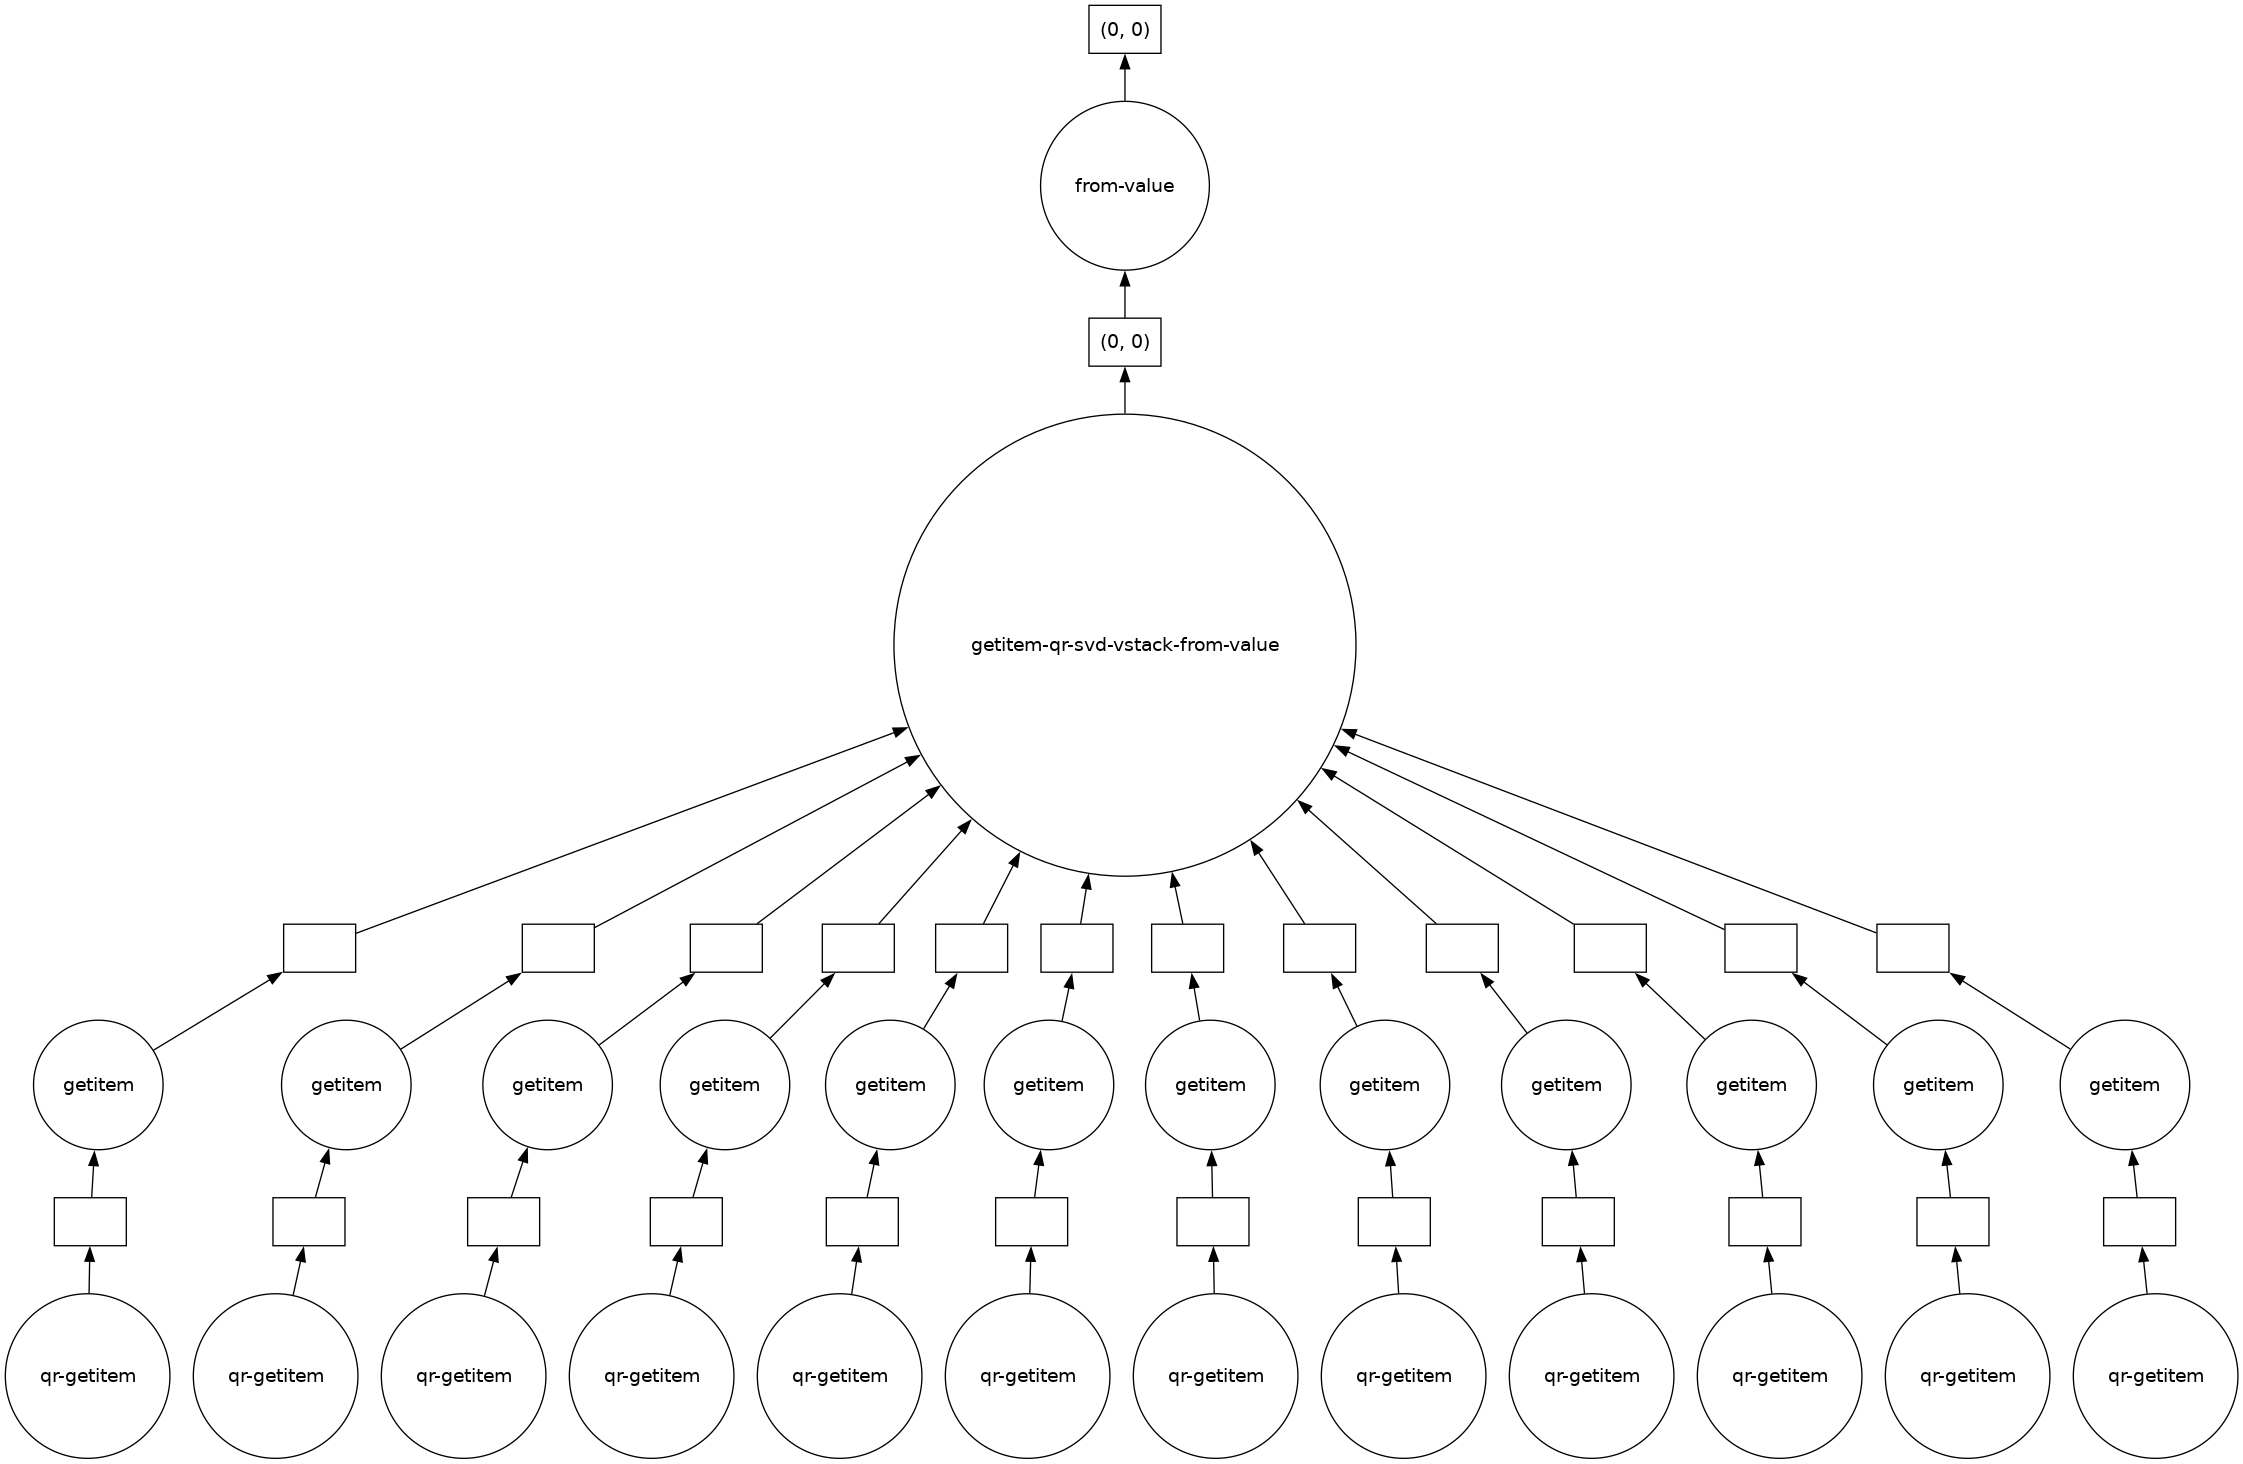

In [7]:
Q_delayed.visualize("./fig/Direct_Q.png", optimize_graph=True)
R_delayed.visualize("./fig/Direct_R.png", optimize_graph=True)

U_delayed.visualize("./fig/Direct_U.png", optimize_graph=True)
S_delayed.visualize("./fig/Direct_S.png", optimize_graph=True)
Vt_delayed.visualize("./fig/Direct_Vt.png", optimize_graph=True)

### HIGGS Dataset
*The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.*
> Whiteson, D. (2014). HIGGS [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5V312.

In [7]:
client.restart()
import dask.dataframe as dd
import os

# Load HIGGS dataset
df = dd.read_csv("./HIGGS.csv", header=None, blocksize="300MB")
df = df.iloc[:, 1:] 
A = df.to_dask_array(lengths=True)

# Persist in memory to avoid recomputation
A = A.persist() 

print(f"Input matrix A: m = {A.shape[0]}, n = {A.shape[1]}")
print(f"Total size of A: {A.nbytes / 1e6} MB")

A

Input matrix A: m = 11000000, n = 28
Total size of A: 2464.0 MB


dask.array<read-_to_string_dtype-values, shape=(11000000, 28), dtype=float64, chunksize=(423080, 28), chunktype=numpy.ndarray>

In [8]:
# QR decomposition (only R is computed explicitly)

Q_delayed_dask, R_delayed_dask = da.linalg.tsqr(A)
Q_delayed, R_delayed = direct_tsqr(A) 

print("-- OUR IMPLEMENTATION (QR) --")
%time R_dask = compute(R_delayed)

print("\n-- DASK'S IMPLEMENTATION (QR) --")
%time R_dask = compute(R_delayed_dask)

check = np.isclose(Q_delayed, Q_delayed_dask, atol=1e-9).all()
print("\nCheck if our implementation is the same as Dask's:", check.compute())

-- OUR IMPLEMENTATION (QR) --
CPU times: user 1.03 s, sys: 230 ms, total: 1.26 s
Wall time: 4.49 s

-- DASK'S IMPLEMENTATION (QR) --
CPU times: user 1.21 s, sys: 189 ms, total: 1.4 s
Wall time: 4.37 s

Check if our implementation is the same as Dask's: True


In [9]:
# SVD decomposition (only S and Vt are computed explicitly)

U_delayed_dask, S_delayed_dask, Vt_delayed_dask = da.linalg.tsqr(A, compute_svd=True)
U_delayed, S_delayed, Vt_delayed = direct_tsqr(A, compute_svd=True)

print("-- OUR IMPLEMENTATION (SVD) --")
%time S, Vt = compute(S_delayed, Vt_delayed)

print("\n-- DASK'S IMPLEMENTATION (SVD) --")
%time S_dask, Vt_dask = compute(S_delayed_dask, Vt_delayed_dask)

check = np.isclose(U_delayed, U_delayed_dask, atol=1e-9).all()
print("\nCheck if our implementation is the same as Dask's:", check.compute())

-- OUR IMPLEMENTATION (SVD) --
CPU times: user 1.37 s, sys: 144 ms, total: 1.51 s
Wall time: 4.48 s

-- DASK'S IMPLEMENTATION (SVD) --
CPU times: user 1.22 s, sys: 178 ms, total: 1.39 s
Wall time: 4.41 s

Check if our implementation is the same as Dask's: True


In [11]:
client.close()